In [3]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.linear_model import LogisticRegression
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [4]:
df = pd.read_csv("../data/survey-lung-cancer.csv")

In [5]:
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,NO,YES,YES,NO,NO,YES,NO,YES,YES,YES,YES,YES,YES,YES
1,M,74,YES,NO,NO,NO,YES,YES,YES,NO,NO,NO,YES,YES,YES,YES
2,F,59,NO,NO,NO,YES,NO,YES,NO,YES,NO,YES,YES,NO,YES,NO
3,M,63,YES,YES,YES,NO,NO,NO,NO,NO,YES,NO,NO,YES,YES,NO
4,F,63,NO,YES,NO,NO,NO,NO,NO,YES,NO,YES,YES,NO,NO,NO


In [6]:
df = df.replace({
    "YES": 1,
    "NO": 0,
    "M": 1,
    "F": 0
})

C:\Users\angel\AppData\Local\Temp\ipykernel_13508\947858454.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({


In [7]:
model = DiscreteBayesianNetwork([
    ('SMOKING', 'LUNG_CANCER'),
    ('AGE', 'LUNG_CANCER'),
    ('COUGHING', 'LUNG_CANCER'),
    ('WHEEZING', 'LUNG_CANCER'),
    ('SHORTNESS OF BREATH', 'LUNG_CANCER'),
    ('CHEST PAIN', 'LUNG_CANCER')
])

In [8]:
model.fit(df, estimator = BayesianEstimator, prior_type = 'BDeu')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GENDER': 'N', 'AGE': 'N', 'SMOKING': 'N', 'YELLOW_FINGERS': 'N', 'ANXIETY': 'N', 'PEER_PRESSURE': 'N', 'CHRONIC DISEASE': 'N', 'FATIGUE ': 'N', 'ALLERGY ': 'N', 'WHEEZING': 'N', 'ALCOHOL CONSUMING': 'N', 'COUGHING': 'N', 'SHORTNESS OF BREATH': 'N', 'SWALLOWING DIFFICULTY': 'N', 'CHEST PAIN': 'N', 'LUNG_CANCER': 'N'}


In [9]:
infer = VariableElimination(model)

In [10]:
query = infer.query(
    variables=['LUNG_CANCER'],
    evidence={
        'SMOKING': 1,
        'WHEEZING': 1,
        'COUGHING': 1
    }
)

In [11]:
print(query)

+----------------+--------------------+
| LUNG_CANCER    |   phi(LUNG_CANCER) |
+================+====================+
| LUNG_CANCER(0) |             0.2903 |
+----------------+--------------------+
| LUNG_CANCER(1) |             0.7097 |
+----------------+--------------------+


# Bayesian Network drawing

In [13]:
G = nx.DiGraph()

In [14]:
G.add_edges_from(model.edges)

In [15]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

<Figure size 1200x800 with 0 Axes>

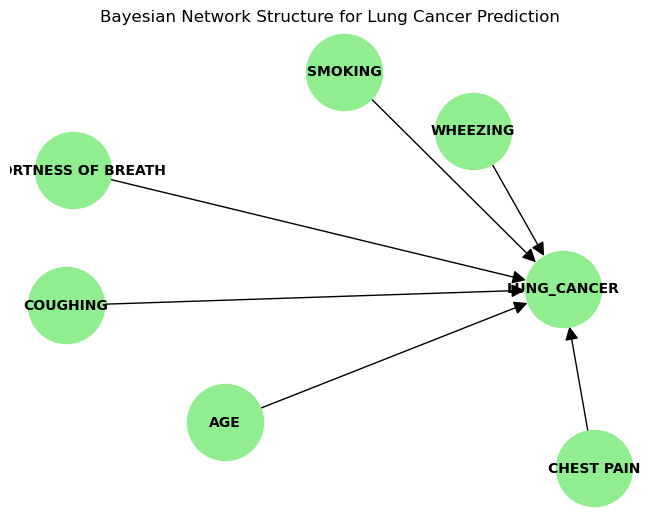

In [16]:
nx.draw(
    G, pos,
    with_labels=True,
    node_size=3000,
    node_color='lightgreen',
    font_size=10,
    font_weight='bold',
    arrowsize=20
)

plt.title('Bayesian Network Structure for Lung Cancer Prediction')
plt.show()

In [17]:
X = df.drop(columns = ['LUNG_CANCER'])
y = df['LUNG_CANCER']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.2, random_state = 42, stratify = y)

In [19]:
rf_model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None,    
    random_state=42
)

In [20]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
y_pred_rf = rf_model.predict(X_test)

In [22]:
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.9193548387096774
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.96      0.94      0.95        54

    accuracy                           0.92        62
   macro avg       0.81      0.85      0.83        62
weighted avg       0.92      0.92      0.92        62



Symptoms like SMOKING, WHEEZING, COUGHING, SHORTNESS OF BREATH, CHEST PAIN are very strong indicators of lung cancer.

Random Forest captures interactions and nonlinear relationships between symptoms automatically.

Even small datasets (~300 patients) are enough because symptoms are very informative.

In [24]:
joblib.dump(rf_model, 'lung_cancer_model.pkl')

['lung_cancer_model.pkl']

In [25]:
importances = rf_model.feature_importances_
feature_names = X.columns  # X is your DataFrame

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                  Feature  Importance
1                     AGE    0.212037
8                ALLERGY     0.090079
10      ALCOHOL CONSUMING    0.079576
5           PEER_PRESSURE    0.073383
3          YELLOW_FINGERS    0.069758
6         CHRONIC DISEASE    0.059096
7                FATIGUE     0.056945
11               COUGHING    0.055679
9                WHEEZING    0.050221
12    SHORTNESS OF BREATH    0.048491
14             CHEST PAIN    0.044399
4                 ANXIETY    0.043972
0                  GENDER    0.041727
13  SWALLOWING DIFFICULTY    0.038713
2                 SMOKING    0.035924


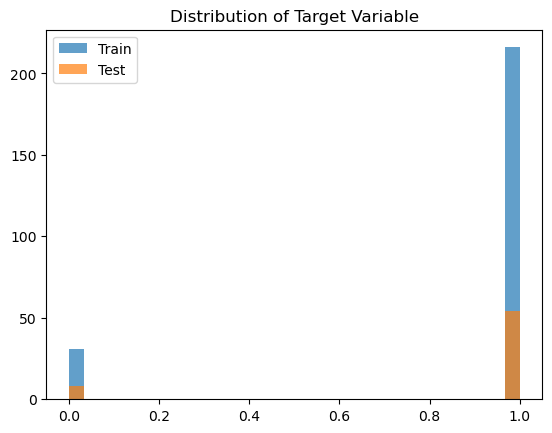

In [26]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=30, alpha=0.7, label='Train')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.legend()
plt.title("Distribution of Target Variable")
plt.show()

## as we can tell model is  higly imbalanced we will use balanced claasifier

In [28]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [29]:
y_new = model.predict(X_test)

In [30]:
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_new))
print(classification_report(y_test, y_new))

Random Forest Performance:
Accuracy: 0.8870967741935484
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.93      0.94      0.94        54

    accuracy                           0.89        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.88      0.89      0.88        62



In [31]:
print(classification_report(y_test, y_new))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.93      0.94      0.94        54

    accuracy                           0.89        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.88      0.89      0.88        62



In [32]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Now fit the model again
new_model = RandomForestClassifier(random_state=42)
new_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [33]:
y_new_new = new_model.predict(X_test)

In [34]:
print(classification_report(y_test, y_new_new))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.98      0.91      0.94        54

    accuracy                           0.90        62
   macro avg       0.78      0.89      0.82        62
weighted avg       0.93      0.90      0.91        62



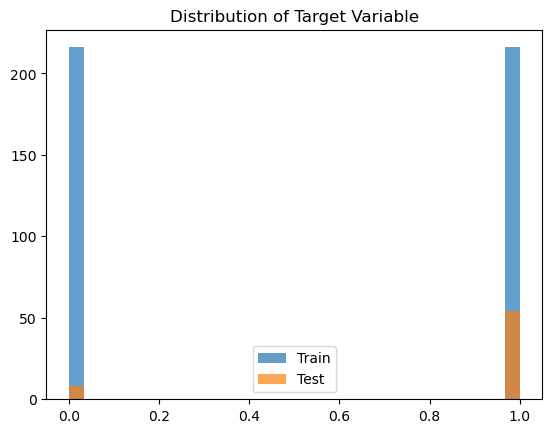

In [35]:
import matplotlib.pyplot as plt
plt.hist(y_resampled, bins=30, alpha=0.7, label='Train')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.legend()
plt.title("Distribution of Target Variable")
plt.show()

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',  # balances both classes
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [37]:
from sklearn.metrics import classification_report

y_prediction = best_model.predict(X_test)
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.98      0.91      0.94        54

    accuracy                           0.90        62
   macro avg       0.78      0.89      0.82        62
weighted avg       0.93      0.90      0.91        62



In [39]:
joblib.dump(best_model, 'new_lung_cancer.pkl')

['new_lung_cancer.pkl']